In [ ]:
## reset specific variables (replace regular_expression by the variables of interest)
#%reset_selective <regular_expression>

# reset all variables
%reset -f

In [268]:
## Importing libraries

from datetime import datetime, date, timedelta
from array import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pylab import savefig
import seaborn as sns
import pandas as pd
import csv
import json
import datetime as dt
from pymongo import MongoClient
from mongoengine import *
import time
import math
from scipy import stats
from tqdm import tqdm
from scipy.stats._continuous_distns import _distn_names as dt_names
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")


ksN = 100          # Kolmogorov-Smirnov KS test for goodness of fit: samples
ALPHA = 0.05 


In [252]:
# Using fitter library

from fitter import Fitter, get_common_distributions, get_distributions

In [264]:
## Changing the distribution variable name to some much more intuitive
#distributions = dt_names

#len(dt_names)
from scipy.stats import (
    norm, beta, cauchy, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    )


distributions = [
    norm, beta, cauchy, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    ]

In [210]:
## reading csv failure time file and converting data to float and 1-D numpy array (for failed SDDs in common)

with open('MergeSSDs_FailureTimesAppWS.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

for i in range(0, len(data)):
    data[i] = float((data[i])[0])

data = np.array(data)
data = np.ceil(data) # making the failure tags more readable

# Saving file for external analysis
df_data = pd.DataFrame(data)
df_data.to_csv('MergeSSDs_FailureTimesAppWSFixed.csv')

In [284]:
## reading csv failure time file and converting data to float and 1-D numpy array (for all failed SDDs)

with open('Snapshot_FailureTimesAppWSM.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

for i in range(0, len(data)):
    data[i] = float((data[i])[0])

data = np.array(data)
data = np.ceil(data) # making the failure tags more readable

# Saving file for external analysis
df_data = pd.DataFrame(data)
df_data.to_csv('Snapshot_FailureTimesAppWSMFixed.csv')

From here on, fitting's method by using Fitter

,sumsquare_error,aic,bic,kl_div
cauchy,0.00000012899786,"2,164.07126241751803","-222,516.90086101472843",0.12802973980229
powerlaw,0.00000018915759,"2,026.57901542114041","-219,094.89759510103613",0.17524157671400
norm,0.00000026214284,"2,068.61225397485896","-216,194.62135864680749",0.28550382365098
lognorm,0.00000026631585,"2,072.08555554714121","-216,044.71116449387046",0.29218727397004
gamma,0.00000027462278,"2,067.76722757912830","-215,770.85230981989298",0.30129977499146


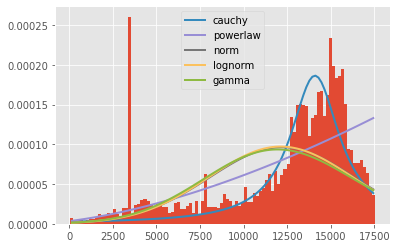

In [285]:
## Fitting using fitter library

f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [302]:
# Identifying the parameters using fitter library

f.fitted_param["cauchy"]

(14091.428806725606, 1707.9932245311848)

In [ ]:
# Get best-fitted distribution and parameters using fitter library

f.get_best(method = 'sumsquare_error')

From here on, fitting's method by using raw scipy - 1st approach

In [286]:
## Fitting function

plt.style.use('ggplot')

def fit_scipy_distributions(array, bins, plot_hist = True, plot_best_fit = True, plot_all_fits = False):
    """
    Fits a range of Scipy's distributions (see scipy.stats) against an array-like input.
    Returns the sum of squared error (SSE) between the fits and the actual distribution.
    Can also choose to plot the array's histogram along with the computed fits.
    N.B. Modify the "CHANGE IF REQUIRED" comments!
    
    Input: array - array-like input
           bins - number of bins wanted for the histogram
           plot_hist - boolean, whether you want to show the histogram
           plot_best_fit - boolean, whether you want to overlay the plot of the best fitting distribution
           plot_all_fits - boolean, whether you want to overlay ALL the fits (can be messy!)
    
    Returns: results - dataframe with SSE and distribution name, in ascending order (i.e. best fit first)
             best_name - string with the name of the best fitting distribution
             best_params - list with the parameters of the best fitting distribution.
    """
    
    if plot_best_fit or plot_all_fits:
        assert plot_hist, "plot_hist must be True if setting plot_best_fit or plot_all_fits to True"
    
    # Returns un-normalised (i.e. counts) histogram
    y, x = np.histogram(np.array(array), bins=bins)
    
    # Some details about the histogram
    bin_width = x[1]-x[0]
    N = len(array)
    x_mid = (x + np.roll(x, -1))[:-1] / 2.0 # go from bin edges to bin middles
    
    # selection of available distributions
    # CHANGE THIS IF REQUIRED
    #DISTRIBUTIONS = [stats.alpha,stats.cauchy,stats.cosine,stats.laplace,stats.levy,stats.levy_l,stats.norm]
    DISTRIBUTIONS = distributions
    if plot_hist:
        fig, ax = plt.subplots()
        h = ax.hist(np.array(array), bins = bins, color = 'w')

    # loop through the distributions and store the sum of squared errors
    # so we know which one eventually will have the best fit
    sses = []
    for dist in tqdm(DISTRIBUTIONS): #tqdm - progress bar
        name = dist.__class__.__name__[:-4]

        params = dist.fit(np.array(array))
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = dist.pdf(x_mid, loc=loc, scale=scale, *arg)
        pdf_scaled = pdf * bin_width * N # to go from pdf back to counts need to un-normalise the pdf

        sse = np.sum((y - pdf_scaled)**2)
        sses.append([sse, name])

        # Not strictly necessary to plot, but pretty patterns
        if plot_all_fits:
            ax.plot(x_mid, pdf_scaled, label = name)
    
    if plot_all_fits:
        plt.legend(loc=1)

    # CHANGE THIS IF REQUIRED
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')

    # Things to return - df of SSE and distribution name, the best distribution and its parameters
    results = pd.DataFrame(sses, columns = ['SSE','distribution']).sort_values(by='SSE') 
    best_name = results.iloc[0]['distribution']
    best_dist = getattr(stats, best_name)
    best_params = best_dist.fit(np.array(array))
    
    if plot_best_fit:
        new_x = np.linspace(x_mid[0] - (bin_width * 2), x_mid[-1] + (bin_width * 2), 1000)
        best_pdf = best_dist.pdf(new_x, *best_params[:-2], loc=best_params[-2], scale=best_params[-1])
        best_pdf_scaled = best_pdf * bin_width * N
        ax.plot(new_x, best_pdf_scaled, label = best_name)
        plt.legend(loc=1)
    
    if plot_hist:
        plt.show()
    
    return results, best_name, best_params

100%|██████████| 62/62 [01:41<00:00,  1.63s/it]


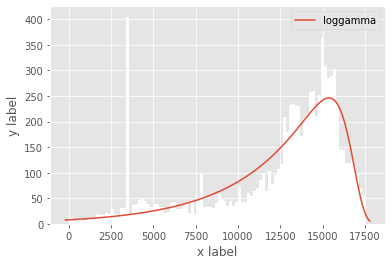

In [287]:
## Example plotting only the best distribution

sses, best_name, best_params = fit_scipy_distributions(data, bins = 100)

In [ ]:
## Example plotting all the fitted distributions

sses, best_name, best_params = fit_scipy_distributions(data, 100, plot_best_fit=False, plot_all_fits=True)


In [281]:
## Showing the best distribution and its parameters

print(best_name)
print(best_params)
sses

loggamma
(0.17479344229521462, 16657.37006653548, 738.3873568105789)


,SSE,distribution
35,"253,444.71269997657510",loggamma
52,"299,813.01182616368169",foldcauchy
1,"311,110.84474870457780",beta
2,"312,007.47592373396037",cauchy
5,"338,818.93620817695046",genextreme
...,...,...
19,"1,996,252.04099948960356",weibull_min
50,"2,525,082.12462568888441",invweibull
44,"2,618,679.98934471793473",powerlognorm
55,"3,443,302.96130563272163",exponweib


From here on, fitting's method by using raw scipy - 2nd approach

In [162]:
## Generating synthetic random variables following a specific statistical distribution (just for testing or the case when any else dataset isn't available)

shp, loc, scl = 1.5, 0, 50000

rv = weibull_min(c=shp, loc=loc, scale=scl)

data = rv.rvs(1000)

In [293]:
def kstest(data, distname, paramtup):
    ks = stats.kstest(data, distname, paramtup, ksN)[1]   # return p-value
    return ks             # return p-value

In [299]:
# distribution fitter and call to KS test

def fitdist(data, dist):    
    fitted = dist.fit(data)
    ks = kstest(data, dist.name, fitted)
    res = (dist.name, ks, *fitted)
    return res

In [ ]:
# call fitting function for all distributions in list
res = [fitdist(data,D) for D in distributions]

# convert the fitted list of tuples to dataframe
pd.options.display.float_format = '{:,.14f}'.format
df = pd.DataFrame(res, columns=["distribution", "KS p-value", "param1", "param2", "param3", "param4", "param5"])
df["distobj"] = distributions
df.sort_values(by=["KS p-value"], inplace=True, ascending=False)
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)
df

In [248]:
def plot_fitted_pdf(df):
    
    N = len(df)
    chrows = math.ceil(N/3)                    # how many rows of charts if 3 in a row
    fig, ax = plt.subplots(chrows, 3, figsize=(20, 5 * chrows))
    ax = ax.ravel()
    dfRV = pd.DataFrame()

    for i in df.index:

        # D_row = df.iloc[i,:-1]
        D_name = df.iloc[i,0]
        D = df.iloc[i,7]
        KSp = df.iloc[i,1]
        params = df.iloc[i,2:7]    
        params = [p for p in params if ~np.isnan(p)]

        # calibrate x-axis by finding the 1% and 99% quantiles in percent point function
        x = np.linspace(
                    D.ppf(0.01, *params), 
                    D.ppf(0.99, *params), 100)

        #fig, ax = plt.subplots(1, 1)
        # plot histogram of actual observations
        ax[i].hist(data, density=True, histtype='stepfilled', alpha=0.2)
        # plot fitted distribution
        rv = D(*params)
        title = f'pdf {D_name}, with p(KS): {KSp:.2f}' 
        ax[i].plot(x, rv.pdf(x), 'r-', lw=2, label=title)
        ax[i].legend(loc="upper right", frameon=False)  

In [249]:
# from dataframe, select distributions with high KS p-value
df_ks = df.loc[df["KS p-value"] > ALPHA]
print(df_ks.shape)
print("Fitted Distributions with KS p-values > ALPHA:")
df_ks

(0, 8)
Fitted Distributions with KS p-values > ALPHA:


,distribution,KS p-value,param1,param2,param3,param4,param5,distobj


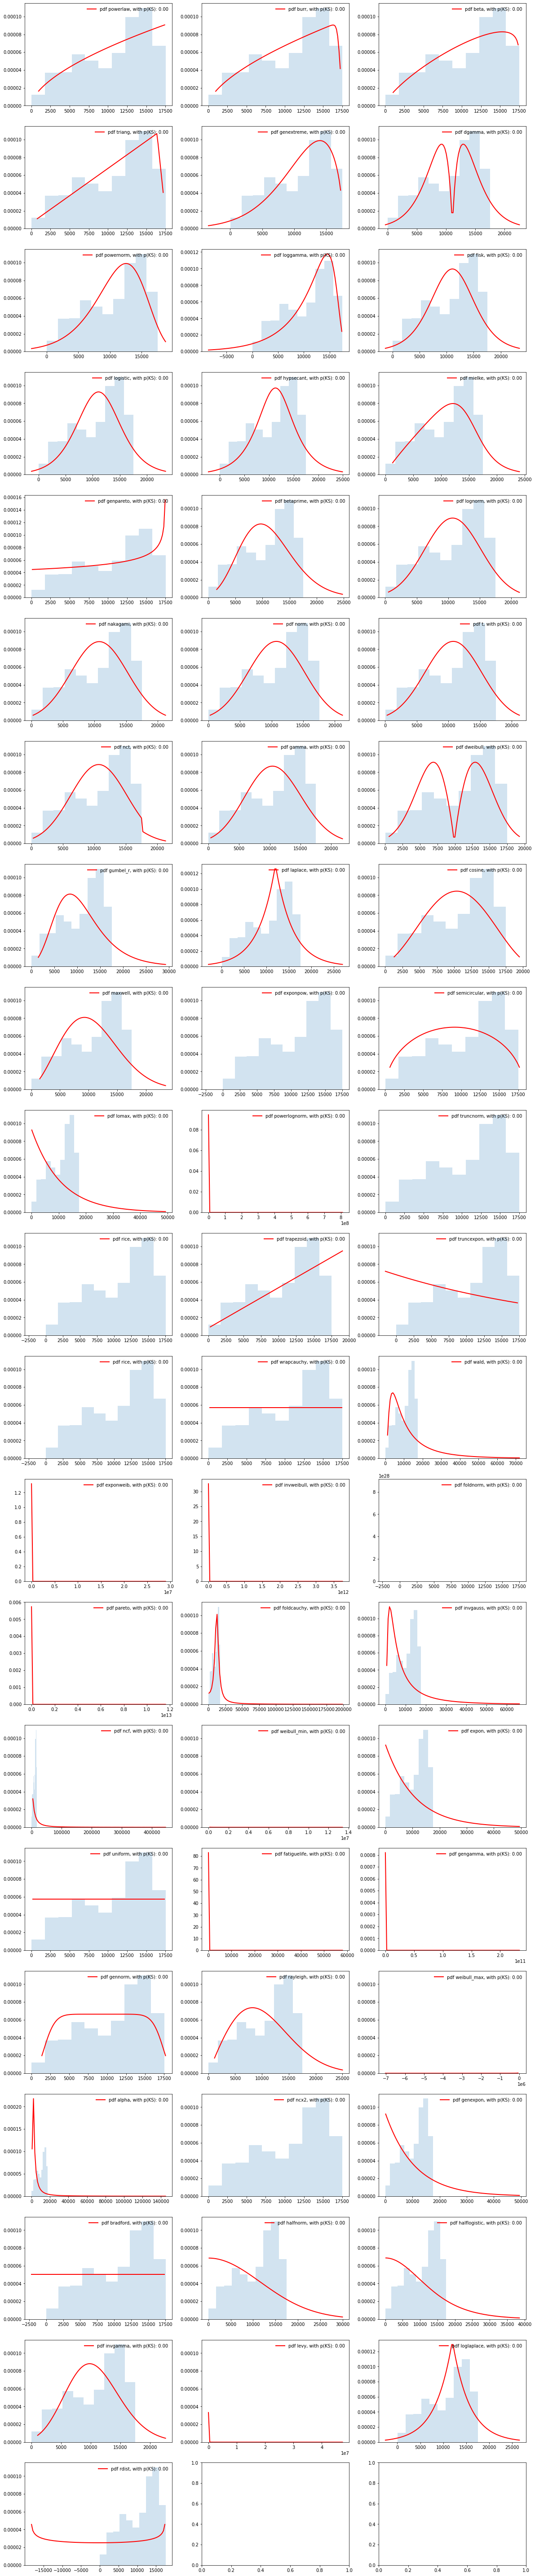

In [251]:
# call the plotting function
plot_fitted_pdf(df_ks)
#plot_fitted_pdf(df)
pass

In [ ]:
# fitted distribution with highest p-value of KS test
D_opt = df_ks.loc[df_ks["KS p-value"].idxmax()]
# D_opt[:-1]

D_opt

In [ ]:
# script takes this best fitting distribution and begins to works with it:
# parameters

print(D_opt.iloc[0])            # name
DO = D_opt.iloc[7]              # distribution object

params = D_opt.iloc[2:7]    
params = [p for p in params if ~np.isnan(p)]
params

In [ ]:
# statistics of the best fitting distribution (4 moments)
stats = DO.stats(*params, "mvsk")
stat_names = ["mean", "variance", "skew", "kurtosis"]
dict_stats = {k:v for k,v in zip(stat_names, stats)} 
_ = [print(k,":",f'{v:.4f}') for k,v in dict_stats.items()]

In [ ]:
# CDF of a chosen x, here the mean
x = dict_stats["mean"]
cdfx = DO.cdf(x, *params)
cdfx

In [ ]:
## EXAMPLE

# mean time to failure
print(f'{rv.mean():.0f}')

In [ ]:
## EXAMPLE

T = 20000

cdfT = rv.cdf(T)           # cumulative failure rate after T hours

svfT = 1 - cdfT
svfT = rv.sf(T)

dict_f = {"at hours":T, "% cumulative failures":cdfT, "surviving % of all components":svfT}
_ = [print(k,":",f'{v:.3f}') for k,v in dict_f.items()]
# svf % of all components will last at least T hours

In [ ]:
## EXAMPLE

# time to a cumulative failure rate of 1%

q = 0.01
ppfq = rv.ppf(q)           

print(f'{ppfq:.0f}', "hours")

In [ ]:
## EXAMPLE
# properties of the beta distribution

a, b = 2, 6

x = beta.rvs(a, b, size=1000)

fig, ax = plt.subplots(1, 1)
ax.hist(x, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass

In [ ]:
## EXAMPLE
# statistics of the Beta(2,6) distribution
m = beta.mean(a,b)
v = beta.var(a,b)
shp_a = beta.a
shp_b = beta.b
median = beta.median(a,b)

dict_stats = {"mean":m, "var":v, "shape a":shp_a, "shape b":shp_b, "median":median}
_ = [print(k,":",f'{v:.3f}') for k,v in dict_stats.items()]

In [ ]:
## EXAMPLE
# plot the pdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='beta pdf')
pass

In [ ]:
## EXAMPLE
# plot the cdf

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.cdf(x), 'r-', lw=5, alpha=0.6, label='beta cdf')
pass

In [ ]:
## EXAMPLE
# plot the inverse cdf or ppf

q = np.linspace(0.0, 1.0, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(q, rv.ppf(q), 'r-', lw=5, alpha=0.6, label='beta inverse cdf')
pass